In [51]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [54]:
X = pd.read_hdf('../data/features/filtered/achat_filtered_0.05_.h5')
y = pd.read_hdf('../data/achat_y.h5')
y_bin = y.astype('category')
y_bin = pd.get_dummies(y_bin)

In [55]:
train = X[X['subject'] < 4].index
test = X[X['subject'] >= 4].index

X_train, X_test, y_train, y_test = X.iloc[train,:], X.iloc[test,:], y_bin.iloc[train,:], y_bin.iloc[test,:]

In [88]:
hyper_par = np.logspace(-4, 4, 21)
auc0 = list()
auc1 = list()
auc2 = list()
coef0 = list()
coef1 = list()
coef2 = list()

for c in hyper_par:
    clf0 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf1 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf2 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf0.fit(X_train, y_train.iloc[:,0])
    clf1.fit(X_train, y_train.iloc[:,1])
    clf2.fit(X_train, y_train.iloc[:,2])
    p0 = clf0.predict_proba(X_test)[:,1]
    p1 = clf1.predict_proba(X_test)[:,1]
    p2 = clf2.predict_proba(X_test)[:,1]
    auc0.append(roc_auc_score(y_test.iloc[:,0], p0))
    auc1.append(roc_auc_score(y_test.iloc[:,1], p1))
    auc2.append(roc_auc_score(y_test.iloc[:,2], p2))
    coef0.append(clf0.coef_)
    coef1.append(clf1.coef_)
    coef2.append(clf2.coef_)

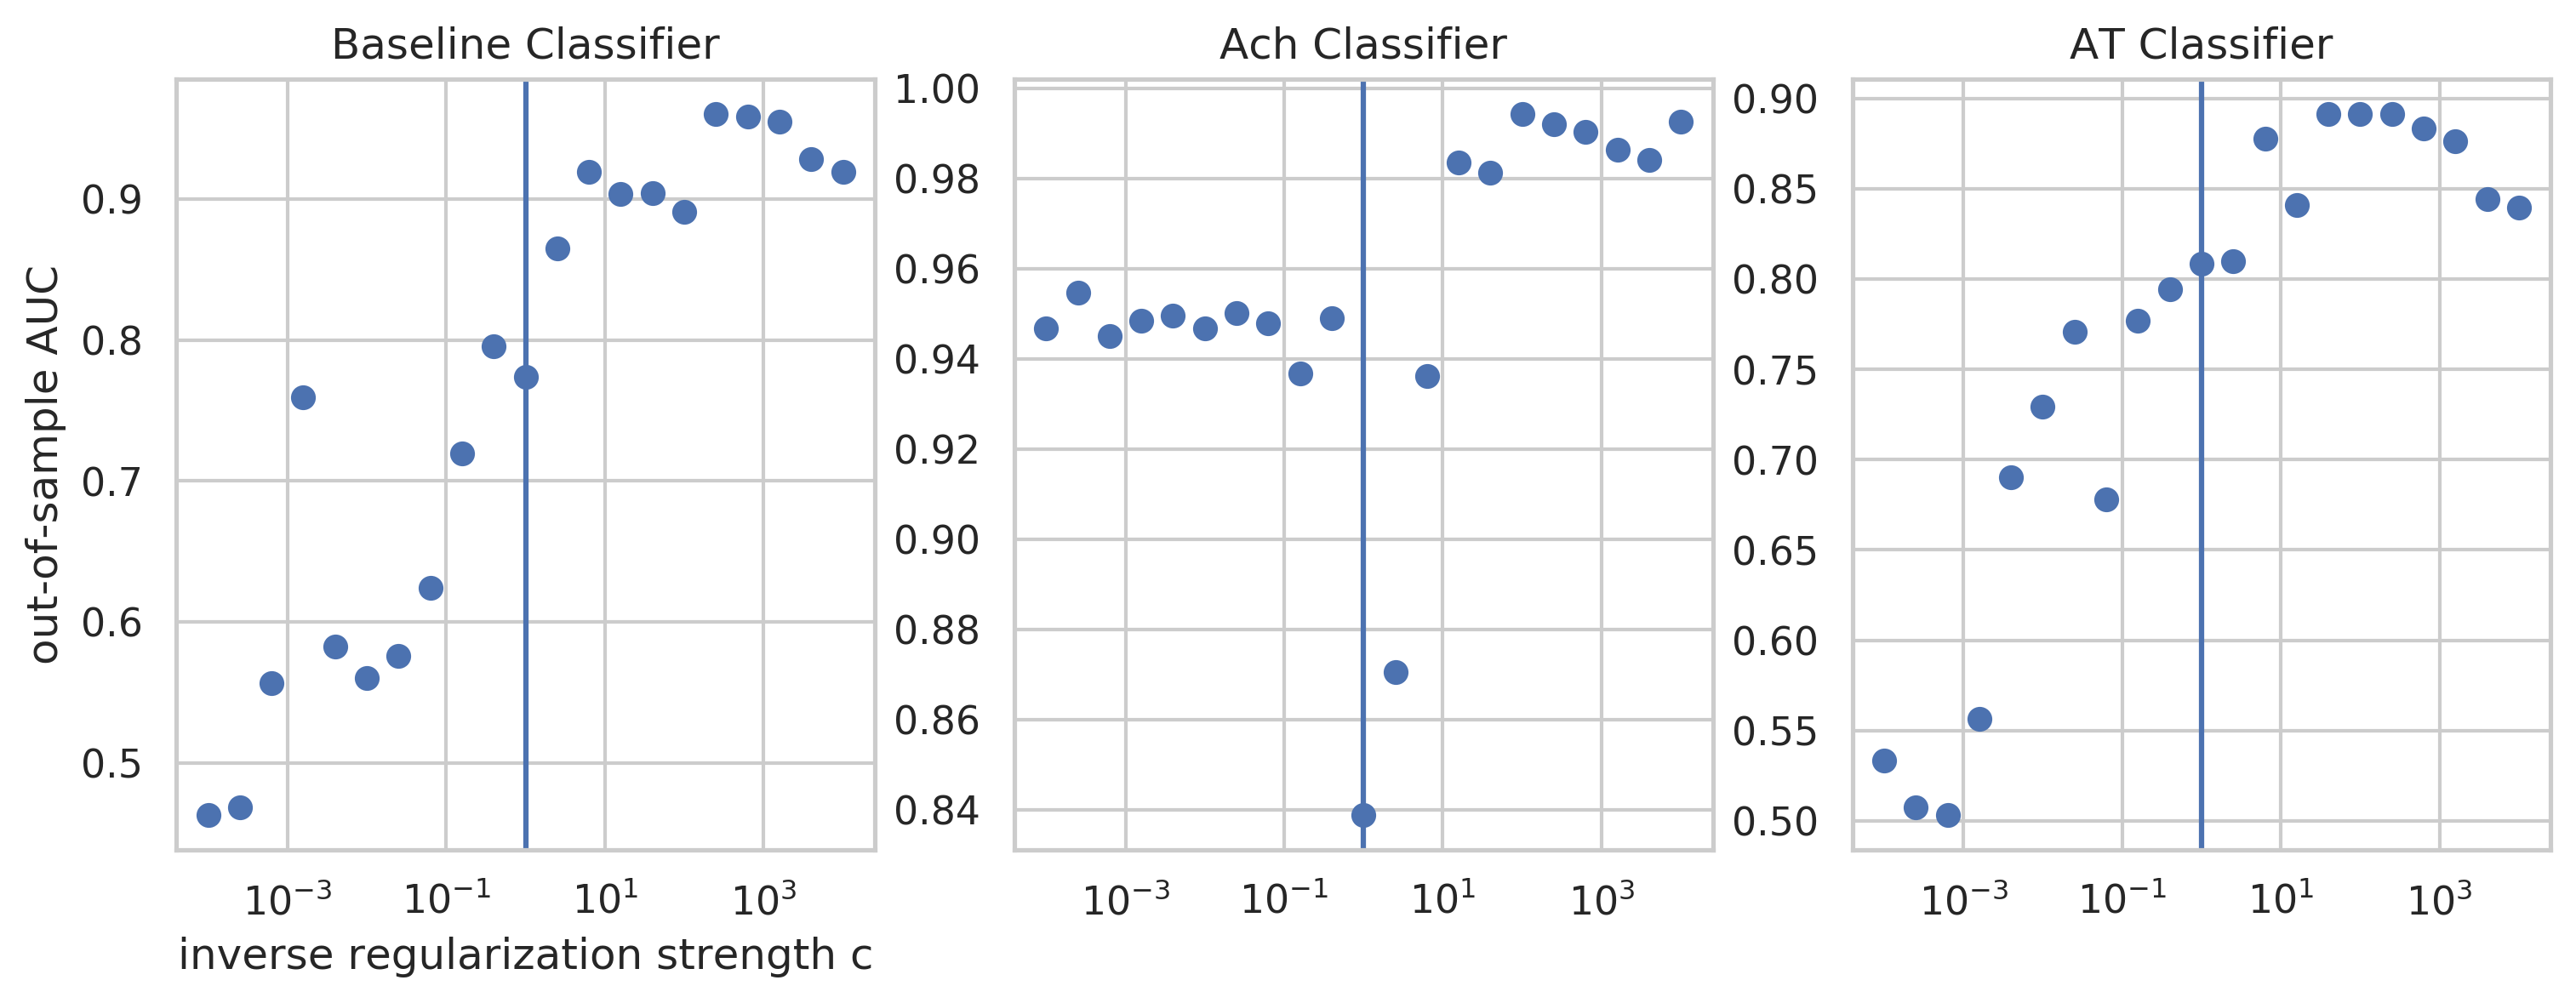

In [101]:
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(131)
plt.semilogx(hyper_par, auc0, 'o')
plt.axvline(1.0)
plt.xlabel('inverse regularization strength c')
plt.ylabel('out-of-sample AUC')
plt.title('Baseline Classifier')
plt.subplot(132)
plt.semilogx(hyper_par, auc1, 'o')
plt.axvline(1.0)
plt.title('Ach Classifier')
plt.subplot(133)
plt.semilogx(hyper_par, auc2, 'o')
plt.axvline(1.0)
plt.title('AT Classifier')
plt.savefig('../reports/figures/logregtuning.png')
plt.show()

In [107]:
importance = pd.Series(abs(clf2.coef_[0]),index=X_train.columns)
importance.sort_values(ascending=False).head(10)

variable
49__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8            64.612597
48__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8            60.688663
37_30_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4    56.619791
52_59_diff__mean_abs_change                                               52.176784
37_30_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2    51.106893
37_30_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2    48.117933
52_59_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0    47.871385
3_56_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2     46.997970
50__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8            38.483770
52_59_diff__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6    37.043972
dtype: float64

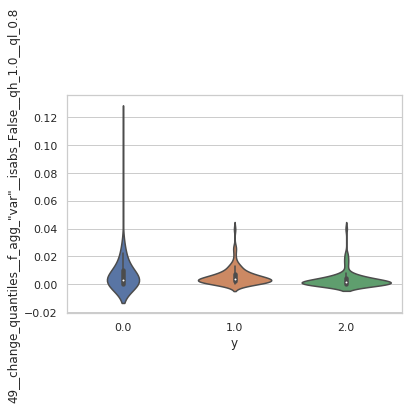

In [109]:
import seaborn as sns
df = X.join(y)
sns.set(style="whitegrid")
ax = sns.violinplot(x="y", y='49__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', data=df)
fig = ax.get_figure()

In [111]:
fname = 'ach_hex_full_6000.h5'
fname[:7]

'ach_hex'